# Validación cruzada
El esquema más simple

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression

# Load dataset
X, y = load_diabetes(return_X_y=True)

# Create a simple train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate
score = model.score(X_test, y_test)
print(f"R² score with simple train-test split: {score:.4f}")

R² score with simple train-test split: 0.4526


Este método tiene el problema de que la estimación de la bondad del modelo depende mucho de los puntos que hayan caído en el set de test.

## Validación cruzada

In [32]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np

def plot_kfold(cv, X, y, ax, n_splits, xlim_max=100):
    """
    Plots the indices for a cross-validation object.

    Parameters:
    cv: Cross-validation object
    X: Feature set
    y: Target variable
    ax: Matplotlib axis object
    n_splits: Number of folds in the cross-validation
    xlim_max: Maximum limit for the x-axis
    """
    
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
    
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
        
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)

        ax.scatter(ax_x, ax_y, c=indices, marker="_", lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)

    # Set y-ticks and labels
    y_ticks = np.arange(n_splits) + 0.5
    ax.set(yticks=y_ticks, yticklabels=range(n_splits), xlabel="X index", ylabel="Fold", ylim=[n_splits, -0.2], xlim=[0, xlim_max])

    # Set plot title and create legend
    ax.set_title("KFold", fontsize=14)
    legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), Patch(color=cmap_cv(0.02), label="Training set")]
    ax.legend(handles=legend_patches, loc=(1.03, 0.8))

In [33]:
from sklearn.model_selection import KFold
import numpy as np

# Initialize the model
model = LinearRegression()

# Define the K-fold cross-validator
n_splits = 5
#kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
kf = KFold(n_splits=n_splits)

# Store scores for each fold
scores = []

# Perform K-Fold CV
for train_index, test_index in kf.split(X):
    # Split data
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Train model
    model.fit(X_train, y_train)
    
    # Evaluate and store score
    score = model.score(X_test, y_test)
    scores.append(score)

print(f"Individual fold scores: {scores}")
print(f"Average score: {np.mean(scores):.4f}")
print(f"Standard deviation: {np.std(scores):.4f}")

Individual fold scores: [0.429556153825838, 0.5225993866099365, 0.48268054134528215, 0.4264977611104024, 0.5502483366517519]
Average score: 0.4823
Standard deviation: 0.0493


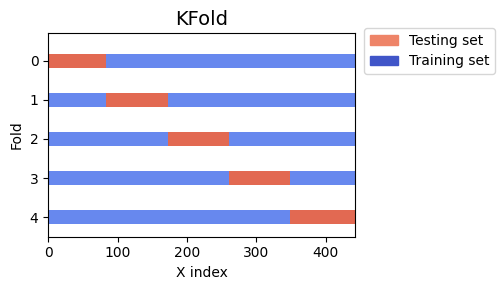

In [35]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 3))
plot_kfold(kf, X, y, ax, n_splits, len(X))
plt.tight_layout()
fig.subplots_adjust(right=0.6)

## Scikit learn cross_val_score

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42), 'SVR': SVR(kernel='rbf')
}

# Evaluate each model with 5-fold CV
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    print(f"{name}:")
    print(f"Mean R²: {scores.mean():.4f}")
    print(f"Std Dev: {scores.std():.4f}")
    print(f"Min-Max: [{scores.min():.4f} - {scores.max():.4f}]\n")

Linear Regression:
Mean R²: 0.4823
Std Dev: 0.0493
Min-Max: [0.4265 - 0.5502]

Random Forest:
Mean R²: 0.4184
Std Dev: 0.0559
Min-Max: [0.3509 - 0.5167]

SVR:
Mean R²: 0.1468
Std Dev: 0.0218
Min-Max: [0.1224 - 0.1820]



## Hyperparameter tuning 

Average difference of 0.007581 with std. dev. of 0.007833.


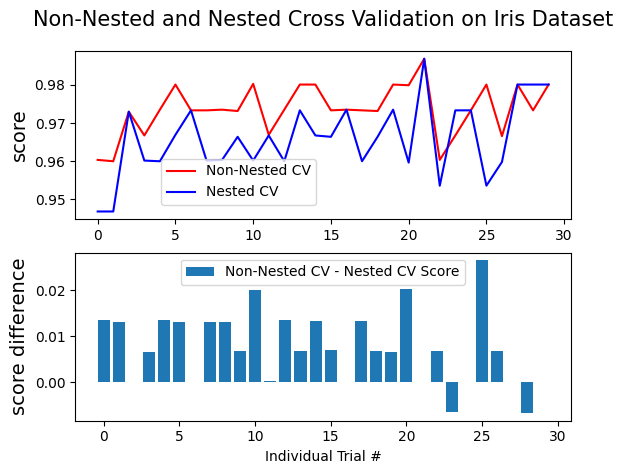

In [9]:
from sklearn.datasets import load_iris
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
# Number of random trials
NUM_TRIALS = 30

# Load the dataset
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

# Set up possible values of parameters to optimize over
p_grid = {"C": [1, 10, 100], "gamma": [0.01, 0.1]}

# We will use a Support Vector Classifier with "rbf" kernel
svm = SVC(kernel="rbf")

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):
    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=outer_cv)
    clf.fit(X_iris, y_iris)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=inner_cv)
    nested_score = cross_val_score(clf, X=X_iris, y=y_iris, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

score_difference = non_nested_scores - nested_scores

print(
    "Average difference of {:6f} with std. dev. of {:6f}.".format(
        score_difference.mean(), score_difference.std()
    )
)

# Plot scores on each trial for nested and non-nested CV
plt.figure()
plt.subplot(211)
(non_nested_scores_line,) = plt.plot(non_nested_scores, color="r")
(nested_line,) = plt.plot(nested_scores, color="b")
plt.ylabel("score", fontsize="14")
plt.legend(
    [non_nested_scores_line, nested_line],
    ["Non-Nested CV", "Nested CV"],
    bbox_to_anchor=(0, 0.4, 0.5, 0),
)
plt.title(
    "Non-Nested and Nested Cross Validation on Iris Dataset",
    x=0.5,
    y=1.1,
    fontsize="15",
)

# Plot bar chart of the difference.
plt.subplot(212)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend(
    [difference_plot],
    ["Non-Nested CV - Nested CV Score"],
    bbox_to_anchor=(0, 1, 0.8, 0),
)
plt.ylabel("score difference", fontsize="14")

plt.show()